In [1]:
import os
import numpy
from PIL import Image
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as implt
import pandas as pd
import  glob
import random

In [2]:
os.rmdir('.virtual_documents') 

In [3]:
'''for i in os.listdir('/kaggle/working'):
    if i!= 'epoch_33.pth':
        for j in os.listdir(os.path.join('/kaggle/working', i)):
            os.remove(os.path.join('/kaggle/working', i, j))
        os.rmdir(os.path.join('/kaggle/working', i))'''

"for i in os.listdir('/kaggle/working'):\n    if i!= 'epoch_33.pth':\n        for j in os.listdir(os.path.join('/kaggle/working', i)):\n            os.remove(os.path.join('/kaggle/working', i, j))\n        os.rmdir(os.path.join('/kaggle/working', i))"

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels of the output image, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=171, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

In [5]:
def get_one_hot_labels(labels, n_classes=20):
    return F.one_hot(labels, n_classes)

def combine_vectors(x, y):
    return torch.cat((x.float(), y.float()), 1)

def get_input_dimensions(z_dim, img_shape=(3, 64, 64), n_classes=20):
    gen_input_dim = z_dim + n_classes
    disc_input_dim = img_shape[0] + n_classes
    
    return gen_input_dim, disc_input_dim

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
      n_samples: the number of samples to generate, a scalar
      z_dim: the dimension of the noise vector, a scalar
      device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [6]:
z_dim = 128
gen_in_dim, _ = get_input_dimensions(z_dim)

In [7]:
device='cuda'
gen = Generator(input_dim=gen_in_dim).to(device)

In [8]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 64, 64)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()
    
def make_grad_hook():
    '''
    Function to keep track of gradients for visualization purposes, 
    which fills the grads list when using model.apply(grad_hook).
    '''
    grads = []
    def grad_hook(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            grads.append(m.weight.grad)
    return grads, grad_hook


In [9]:
classes = sorted(os.listdir('/kaggle/input/stsd-traffic-sign/croppedimgs'))

In [10]:
gen_weights = torch.load('/kaggle/input/stsd-gan-model/generator-STSD.pth')
gen.load_state_dict(gen_weights)
gen.eval()

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(148, 256, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2))
      (1): Tanh()
    )
  )
)

In [11]:
count = 4900*20
labels=[]
for i in range(20):
    labels += [i]*4900


test_noise = get_noise(count, z_dim, device)
test_label = torch.tensor(labels)
test_OH_label = get_one_hot_labels(test_label.to(device))

In [12]:
test_noise_and_label = combine_vectors(test_noise, test_OH_label)
test_image_fake = gen(test_noise_and_label)

In [13]:
!mkdir images

In [14]:
for i in classes:
    os.mkdir(os.path.join('images',i))

In [13]:
def add_nofilter(img):
    return img

def add_highBeam(img):
    
    # Define gamma and gain
    gamma = 0.7
    gain = 1

    # Apply gamma correction
    x_transformed = gain * torch.pow((img), gamma)

    return transforms.functional.adjust_gamma(img, 0.1,1)

def add_fog(img):
    # Define fog intensity and contrast reduction
    fog_intensity = 0.2  # adjust this value to control fog density
    contrast_reduction = 0.5  # adjust this value to control contrast

    # Create a fog layer
    fog_layer = torch.rand_like(img) * fog_intensity

    # Reduce contrast and sharpness
    img_foggy = torch.pow(img, contrast_reduction)

    # Combine the fog layer and the image
    img_foggy = img_foggy * (1 - fog_layer) + fog_layer
    img_foggy = img_foggy*0.35
    
    return img_foggy

def add_snow(img_batch):
    img_batch = img_batch[None,:]
    imgcopy = img_batch.clone()
    num_images, _, row, col = img_batch.shape
    for i in range(num_images):
        number_of_pixels = random.randint(15, 25)
        for _ in range(number_of_pixels): 
            y_coord = random.randint(0, row - 1)
            x_coord = random.randint(0, col - 1) 
            imgcopy[i, :, y_coord, x_coord] = 1.0
    return imgcopy[0]

def add_rain(img_batch):
    img_batch = img_batch[None,:]
    imgcopy = img_batch.clone()
    num_images, _, row, col = img_batch.shape
    for i in range(num_images):
        number_of_pixels = random.randint(15, 25)
        for _ in range(number_of_pixels): 
            y_coord = random.randint(0, row - 2)
            x_coord = random.randint(0, col - 1) 
            imgcopy[i, :, y_coord, x_coord] = 128/255
            if random.randint(0, 1):
                imgcopy[i, :, y_coord+1, x_coord] = 128/255
                
    return imgcopy[0]

In [14]:
list_of_functions = [add_nofilter, add_snow, add_rain, add_highBeam, add_fog]

In [39]:
for index, i in enumerate(test_image_fake):
    random_function = random.sample(list_of_functions,1)[0]
    i = (i+1)/2
    numpy_image = random_function(i).to('cpu').detach().permute(1,2,0).numpy()
    numpy_image = (numpy_image-np.min(numpy_image))/(np.max(numpy_image) - np.min(numpy_image))
    plt.imsave(os.path.join('/kaggle/working/images',classes[index//4800],str(index%4800)) + '.jpg', numpy_image)
    

In [15]:
for index, i in enumerate(test_image_fake):
    random_function = random.sample(list_of_functions,1)[0]
    i = (i+1)/2
    numpy_image = random_function(i).to('cpu').detach().permute(1,2,0).numpy()
    numpy_image = (numpy_image-np.min(numpy_image))/(np.max(numpy_image) - np.min(numpy_image))
    plt.imsave(os.path.join('/kaggle/working/images',classes[index//4900],str(4800 + index%4900)) + '.jpg', numpy_image)

In [16]:
for className in classes:
    classPath = os.path.join('/kaggle/input/stsd-traffic-sign/croppedimgs',className)
    for index, imageName in enumerate(os.listdir(classPath)):
        random_function = random.sample(list_of_functions,1)[0]
        img = implt.imread(os.path.join(classPath, imageName))
        filtered_image = random_function(torch.tensor(img/255., device='cpu').permute(2,0,1)).permute(1,2,0).numpy()
        filtered_image = (filtered_image-np.min(filtered_image))/(np.max(filtered_image) - np.min(filtered_image))
        outputPath = os.path.join('/kaggle/working/images', className, str(9700+index)) + '.jpg'
        plt.imsave(outputPath, filtered_image)

In [18]:
import shutil
shutil.make_archive('/kaggle/working/generated_images', 'zip', '/kaggle/working/images')

'/kaggle/working/generated_images.zip'

In [7]:
!rm /kaggle/working/generated_images.zip

In [17]:
import os
s=0
for i in os.listdir('/kaggle/working/images'):
    if i != 'epoch_33.pth':
        s += len(os.listdir(os.path.join('/kaggle/working/images', i)))
s

197169

# **ViT Model**

In [1]:
# Install necessary modules
!pip install torch-summary
!pip install torchmetrics

In [2]:
# Import Dependencies
import os
import numpy as np
import pandas as pd
import cv2
import random
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import math
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import torch
from torchsummary import summary
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from typing import Dict, List, Tuple
from tqdm import tqdm
from torchmetrics import Accuracy, F1Score, Recall, Precision

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
os.rmdir('.virtual_documents') 

In [4]:
# List of class names as considered by data loader
x = sorted(os.listdir('/kaggle/working/images'))

# Convert list of class names into dictionary
classes = {key: value for key, value in enumerate(x)}

In [5]:
# Define Image Transforms
transform = transforms.Compose([
    transforms.Resize((81, 81)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Dataset of entire data
full_dataset = datasets.ImageFolder(root='/kaggle/working/images', transform=transform)

In [6]:
len(full_dataset)

197169

In [7]:
train_size = int(0.8 * len(full_dataset)) # Split data count into training and validation splits in the ratio 80% to 20%
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size]) # Split the data

In [8]:
batch_size = 128  #Set batch size
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # Create train dataloader
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True) # Create valiation dataloader

In [9]:
# Patch Embedding Class
class PatchEmbedding(nn.Module):
    '''
    Creates Patch Embedding layer to patch the input features from Xception model backbone, and flattens it.
    '''
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=3,
                 embedding_dim:int=3*3*3):
        super().__init__()
        
        #  Layer to turn features into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        #  Layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        
        
    def forward(self, x):
        
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        
        return x_flattened.permute(0, 2, 1)

In [10]:
# Multi-head Self Attention Class
class MultiheadSelfAttentionBlock(nn.Module):
    """
    Creates a multi-head self-attention block.
    """

    def __init__(self,
                 embedding_dim:int=3*3*3, 
                 num_heads:int=3, 
                 attn_dropout:float=0): 
        super().__init__()
 
        # Layer Normalization
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # Multi-Head Attention layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, 
                                             key=x,
                                             value=x,
                                             need_weights=False)
        return attn_output

In [11]:
# MLP (Multilayer Perceptron) Class
class MLPBlock(nn.Module):
    """Creates a Layer Normalized Multilayer Perceptron block."""
    def __init__(self,
                 embedding_dim:int=3*3*3,
                 mlp_size:int=3072,
                 dropout:float=0.1):
        super().__init__()
        
        # Norm layer 
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # MLP layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size,
                      out_features=embedding_dim), 
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [12]:
# Transformer Encoder Class
class TransformerEncoderBlock(nn.Module):
    """
    Creates a Transformer Encoder block.
    """
    
    def __init__(self,
                 embedding_dim:int=3*3*3,
                 num_heads:int=3, 
                 mlp_size:int=3072,
                 mlp_dropout:float=0.1, 
                 attn_dropout:float=0): 
        super().__init__()

        # Multi-head Self Attention Block
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # MLP Block
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    def forward(self, x):
        
        x =  self.msa_block(x) + x 
        x = self.mlp_block(x) + x 
        
        return x

In [13]:
# Separable Conv2D Class
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

In [14]:
# Xception Block Class
class Block(nn.Module):
    def __init__(self,in_filters,out_filters,reps,strides=1,start_with_relu=True,grow_first=True):
        super(Block, self).__init__()

        if out_filters != in_filters or strides!=1:
            self.skip = nn.Conv2d(in_filters,out_filters,1,stride=strides, bias=False)
            self.skipbn = nn.BatchNorm2d(out_filters)
        else:
            self.skip=None
        
        self.relu = nn.ReLU(inplace=True)
        rep=[]

        filters=in_filters
        if grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))
            filters = out_filters

        for i in range(reps-1):
            rep.append(self.relu)
            rep.append(SeparableConv2d(filters,filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(filters))
        
        if not grow_first:
            rep.append(self.relu)
            rep.append(SeparableConv2d(in_filters,out_filters,3,stride=1,padding=1,bias=False))
            rep.append(nn.BatchNorm2d(out_filters))

        if not start_with_relu:
            rep = rep[1:]
        else:
            rep[0] = nn.ReLU(inplace=False)

        if strides != 1:
            rep.append(nn.MaxPool2d(3,strides,1))
        self.rep = nn.Sequential(*rep)

    def forward(self,inp):
        x = self.rep(inp)

        if self.skip is not None:
            skip = self.skip(inp)
            skip = self.skipbn(skip)
        else:
            skip = inp

        x+=skip
        return x

In [15]:
class Xception(nn.Module):
    def __init__(self, num_classes=1000):
        super(Xception, self).__init__()
        
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(3, 32, 3,2, 0, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(32,64,3,bias=False)
        self.bn2 = nn.BatchNorm2d(64)

        self.block1=Block(64,128,2,2,start_with_relu=False,grow_first=True)
        self.block2=Block(128,256,2,2,start_with_relu=True,grow_first=True)
        self.block3=Block(256,728,2,2,start_with_relu=True,grow_first=True)

        self.block4=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block5=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block6=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block7=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block8=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block9=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block10=Block(728,728,3,1,start_with_relu=True,grow_first=True)
        self.block11=Block(728,728,3,1,start_with_relu=True,grow_first=True)

        self.block12=Block(728,1024,2,2,start_with_relu=True,grow_first=False)

        self.conv3 = SeparableConv2d(1024,1536,3,1,1)
        self.bn3 = nn.BatchNorm2d(1536)

        self.conv4 = SeparableConv2d(1536,2048,3,1,1)
        self.bn4 = nn.BatchNorm2d(2048)
        
        self.upsample = nn.Upsample((2, 2))
        self.convtranspose = nn.ConvTranspose2d(2048, 3, kernel_size=5, stride=4)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.block9(x)
        x = self.block10(x)
        x = self.block11(x)
        x = self.block12(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        
        x = self.upsample(x)
        x = self.upsample(x)
        x = self.convtranspose(x)

        return x

In [16]:
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with Xception Model backbone."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=9, # Feature map resolution
                 in_channels:int=3, # Number of channels in input feature map
                 patch_size:int=3, # Patch size
                 num_transformer_layers:int=12,
                 embedding_dim:int=3*3*3,
                 mlp_size:int=3072, # MLP size
                 num_heads:int=3,
                 attn_dropout:float=0, # Dropout for Attention Projection
                 mlp_dropout:float=0.1, # Dropout for MLP layers 
                 embedding_dropout:float=0.1, # Dropout for Patch and Position Embeddings
                 num_classes:int=94): # Total number of traffic sign classes 
        
        super().__init__()
        
        self.xception_model = Xception()
        
        # Calculate Number of Patches ((height * width)/(patch^2))
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # Learnable Class Embedding
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # Learnable Position Embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # Embedding Dropout
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # Patch Embedding Layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # Create Transformer Encoder Blocks
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # Create Classifier Head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
        
    def forward(self, x):
        
        x = self.xception_model(x)
        
        # Get Batch size
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1)

        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x

        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        
        x = self.classifier(x[:, 0])
        
        return x   

In [17]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device,
               train_acc_metric,
               train_f1_metric,
               train_recall_metric,
               train_prec_metric) -> Tuple[float, float, float, float, float]:
    
    model.train()
    
    train_loss, acc, f1, recall, precision = 0, 0, 0, 0, 0

    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Update metrics
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        acc += train_acc_metric(y_pred_class, y)
        f1 += train_f1_metric(y_pred_class, y)
        recall += train_recall_metric(y_pred_class, y)
        precision += train_prec_metric(y_pred_class, y)

    # Compute metrics
    train_loss = train_loss / len(dataloader)
    train_acc = acc / len(dataloader)
    train_f1 = f1 / len(dataloader)
    train_rec = recall / len(dataloader)
    train_precision = precision / len(dataloader)

    return train_loss, train_acc, train_f1, train_rec, train_precision

In [18]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module, 
              device: torch.device,
              test_f1_metric,
              test_recall_metric,
              test_acc_metric,
              test_prec_metric) -> Tuple[float, float, float, float, float]:
    
    model.eval()

    test_loss, acc, f1, recall, precision = 0, 0, 0, 0, 0

    with torch.no_grad():
        for batch, (X, y) in tqdm(enumerate(dataloader)):
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate and accumulate loss
            loss = loss_fn(y_pred, y)
            test_loss += loss.item() 

            # Update metrics
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            acc += test_acc_metric(y_pred_class, y)
            f1 += test_f1_metric(y_pred_class, y)
            recall += test_recall_metric(y_pred_class, y)
            precision += test_prec_metric(y_pred_class, y)

    # Compute metrics
    test_loss = test_loss / len(dataloader)
    test_acc = acc / len(dataloader)
    test_f1 = f1 / len(dataloader)
    test_rec = recall / len(dataloader)
    test_precision = precision / len(dataloader)

    return test_loss, test_acc, test_f1, test_rec, test_precision

In [19]:
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Initialize metrics
    train_acc_metric = Accuracy(task="multiclass", num_classes=94).to(device)
    train_f1_metric = F1Score(task="multiclass", average='macro', num_classes=94).to(device)
    train_recall_metric = Recall(task="multiclass", average='macro', num_classes=94).to(device)
    train_prec_metric = Precision(task="multiclass", average='macro', num_classes=94).to(device)

    test_acc_metric = Accuracy(task="multiclass", num_classes=94).to(device)
    test_f1_metric = F1Score(task="multiclass", average='macro', num_classes=94).to(device)
    test_recall_metric = Recall(task="multiclass", average='macro', num_classes=94).to(device)
    test_prec_metric = Precision(task="multiclass", average='macro', num_classes=94).to(device)

    results = {"train_loss": [],
               "train_acc": [],
               "train_f1_score": [],
               "train_recall": [],
               "train_precision": [],
               "val_loss": [],
               "val_acc": [],
               "val_f1_score": [],
               "val_recall": [],
               "val_precision": []
    }
    
    model.to(device)

    for epoch in range(epochs):   
        train_loss, train_acc, train_f1_score, train_recall, train_precision = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device,
                                          train_acc_metric=train_acc_metric,
                                          train_f1_metric=train_f1_metric,
                                          train_recall_metric=train_recall_metric,
                                          train_prec_metric=train_prec_metric)
                                          
        test_loss, test_acc, test_f1_score, test_recall, test_precision = test_step(model=model,
                                  dataloader=test_dataloader,
                                  loss_fn=loss_fn,
                                  device=device,
                                  test_acc_metric=test_acc_metric,
                                  test_f1_metric=test_f1_metric,
                                  test_recall_metric=test_recall_metric,
                                  test_prec_metric=test_prec_metric)

        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"train_F1_score: {train_f1_score:.4f} | "
          f"train_recall: {train_recall:.4f} | "
          f"train_precision: {train_precision:.4f} | "
          f"val_loss: {test_loss:.4f} | "
          f"val_acc: {test_acc:.4f} | "
          f"val_F1_score: {test_f1_score:.4f} | "
          f"val_recall: {test_recall:.4f} | "
          f"val_precision: {test_precision:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_f1_score"].append(train_f1_score)
        results["train_recall"].append(train_recall)
        results["train_precision"].append(train_precision)
        results["val_loss"].append(test_loss)
        results["val_acc"].append(test_acc)
        results["val_f1_score"].append(test_f1_score)
        results["val_recall"].append(test_recall)
        results["val_precision"].append(test_precision)
        
        if epoch in [31, 63, 95, 127]:
            torch.save(
                obj=model.state_dict(),
                f=f"/kaggle/working/epoch_{epoch+1}.pth"
            )

    return results


In [20]:
# Initialize Model
model = ViT()

In [21]:
# Initialize optimizer, loss and device to train on
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))
loss = nn.CrossEntropyLoss()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [22]:
# Train the model and store the results in "history" variable
history = train(model=model,
       train_dataloader=train_dataloader,
       test_dataloader=val_dataloader,
       optimizer=optimizer,
       loss_fn=loss,
       epochs=94,
       device=device)

1233it [06:27,  3.18it/s]
309it [00:44,  6.99it/s]


Epoch: 1 | train_loss: 0.4913 | train_acc: 0.8773 | train_F1_score: 0.8632 | train_recall: 0.8785 | train_precision: 0.8701 | val_loss: 0.0815 | val_acc: 0.9796 | val_F1_score: 0.9767 | val_recall: 0.9784 | val_precision: 0.9794


1233it [06:18,  3.26it/s]
309it [00:43,  7.13it/s]


Epoch: 2 | train_loss: 0.0561 | train_acc: 0.9861 | train_F1_score: 0.9844 | train_recall: 0.9863 | train_precision: 0.9857 | val_loss: 0.0997 | val_acc: 0.9763 | val_F1_score: 0.9737 | val_recall: 0.9753 | val_precision: 0.9772


1233it [06:17,  3.26it/s]
309it [00:43,  7.16it/s]


Epoch: 3 | train_loss: 0.0423 | train_acc: 0.9895 | train_F1_score: 0.9882 | train_recall: 0.9898 | train_precision: 0.9889 | val_loss: 0.0314 | val_acc: 0.9921 | val_F1_score: 0.9913 | val_recall: 0.9921 | val_precision: 0.9922


1233it [06:17,  3.26it/s]
309it [00:43,  7.18it/s]


Epoch: 4 | train_loss: 0.0300 | train_acc: 0.9923 | train_F1_score: 0.9913 | train_recall: 0.9924 | train_precision: 0.9919 | val_loss: 0.0307 | val_acc: 0.9920 | val_F1_score: 0.9910 | val_recall: 0.9920 | val_precision: 0.9918


1233it [06:20,  3.24it/s]
309it [00:43,  7.13it/s]


Epoch: 5 | train_loss: 0.0290 | train_acc: 0.9925 | train_F1_score: 0.9916 | train_recall: 0.9926 | train_precision: 0.9922 | val_loss: 0.0256 | val_acc: 0.9929 | val_F1_score: 0.9923 | val_recall: 0.9930 | val_precision: 0.9930


1233it [06:17,  3.27it/s]
309it [00:43,  7.14it/s]


Epoch: 6 | train_loss: 0.0203 | train_acc: 0.9947 | train_F1_score: 0.9942 | train_recall: 0.9948 | train_precision: 0.9946 | val_loss: 0.0224 | val_acc: 0.9941 | val_F1_score: 0.9938 | val_recall: 0.9943 | val_precision: 0.9943


1233it [06:18,  3.26it/s]
309it [00:43,  7.10it/s]


Epoch: 7 | train_loss: 0.0189 | train_acc: 0.9948 | train_F1_score: 0.9942 | train_recall: 0.9949 | train_precision: 0.9946 | val_loss: 0.0613 | val_acc: 0.9837 | val_F1_score: 0.9820 | val_recall: 0.9838 | val_precision: 0.9836


1233it [06:17,  3.26it/s]
309it [00:43,  7.14it/s]


Epoch: 8 | train_loss: 0.0173 | train_acc: 0.9955 | train_F1_score: 0.9950 | train_recall: 0.9957 | train_precision: 0.9953 | val_loss: 0.0229 | val_acc: 0.9939 | val_F1_score: 0.9933 | val_recall: 0.9940 | val_precision: 0.9939


1233it [06:17,  3.27it/s]
309it [00:43,  7.17it/s]


Epoch: 9 | train_loss: 0.0143 | train_acc: 0.9961 | train_F1_score: 0.9956 | train_recall: 0.9961 | train_precision: 0.9958 | val_loss: 0.0870 | val_acc: 0.9823 | val_F1_score: 0.9813 | val_recall: 0.9826 | val_precision: 0.9844


1233it [06:17,  3.27it/s]
309it [00:43,  7.14it/s]


Epoch: 10 | train_loss: 0.0127 | train_acc: 0.9965 | train_F1_score: 0.9961 | train_recall: 0.9966 | train_precision: 0.9963 | val_loss: 0.0347 | val_acc: 0.9917 | val_F1_score: 0.9908 | val_recall: 0.9918 | val_precision: 0.9915


1233it [06:17,  3.27it/s]
309it [00:43,  7.11it/s]


Epoch: 11 | train_loss: 0.0117 | train_acc: 0.9969 | train_F1_score: 0.9966 | train_recall: 0.9971 | train_precision: 0.9968 | val_loss: 0.0291 | val_acc: 0.9921 | val_F1_score: 0.9910 | val_recall: 0.9921 | val_precision: 0.9918


1233it [06:19,  3.25it/s]
309it [00:43,  7.04it/s]


Epoch: 12 | train_loss: 0.0114 | train_acc: 0.9970 | train_F1_score: 0.9966 | train_recall: 0.9970 | train_precision: 0.9969 | val_loss: 0.0157 | val_acc: 0.9959 | val_F1_score: 0.9954 | val_recall: 0.9959 | val_precision: 0.9958


1233it [06:20,  3.24it/s]
309it [00:43,  7.05it/s]


Epoch: 13 | train_loss: 0.0092 | train_acc: 0.9976 | train_F1_score: 0.9973 | train_recall: 0.9977 | train_precision: 0.9974 | val_loss: 0.0250 | val_acc: 0.9944 | val_F1_score: 0.9938 | val_recall: 0.9943 | val_precision: 0.9945


1233it [06:20,  3.24it/s]
309it [00:43,  7.03it/s]


Epoch: 14 | train_loss: 0.0085 | train_acc: 0.9978 | train_F1_score: 0.9976 | train_recall: 0.9979 | train_precision: 0.9977 | val_loss: 0.0260 | val_acc: 0.9938 | val_F1_score: 0.9931 | val_recall: 0.9937 | val_precision: 0.9939


1233it [06:20,  3.24it/s]
309it [00:43,  7.07it/s]


Epoch: 15 | train_loss: 0.0079 | train_acc: 0.9979 | train_F1_score: 0.9976 | train_recall: 0.9980 | train_precision: 0.9976 | val_loss: 0.0197 | val_acc: 0.9955 | val_F1_score: 0.9950 | val_recall: 0.9955 | val_precision: 0.9955


1233it [06:17,  3.27it/s]
309it [00:43,  7.16it/s]


Epoch: 16 | train_loss: 0.0070 | train_acc: 0.9981 | train_F1_score: 0.9979 | train_recall: 0.9982 | train_precision: 0.9980 | val_loss: 0.0186 | val_acc: 0.9953 | val_F1_score: 0.9948 | val_recall: 0.9953 | val_precision: 0.9953


1233it [06:17,  3.27it/s]
309it [00:43,  7.16it/s]


Epoch: 17 | train_loss: 0.0075 | train_acc: 0.9979 | train_F1_score: 0.9977 | train_recall: 0.9980 | train_precision: 0.9978 | val_loss: 0.0199 | val_acc: 0.9950 | val_F1_score: 0.9944 | val_recall: 0.9949 | val_precision: 0.9948


1233it [06:17,  3.27it/s]
309it [00:43,  7.10it/s]


Epoch: 18 | train_loss: 0.0057 | train_acc: 0.9983 | train_F1_score: 0.9982 | train_recall: 0.9985 | train_precision: 0.9982 | val_loss: 0.0321 | val_acc: 0.9928 | val_F1_score: 0.9921 | val_recall: 0.9928 | val_precision: 0.9929


1233it [06:19,  3.25it/s]
309it [00:43,  7.12it/s]


Epoch: 19 | train_loss: 0.0056 | train_acc: 0.9985 | train_F1_score: 0.9984 | train_recall: 0.9986 | train_precision: 0.9985 | val_loss: 0.0179 | val_acc: 0.9958 | val_F1_score: 0.9954 | val_recall: 0.9958 | val_precision: 0.9958


1233it [06:18,  3.26it/s]
309it [00:43,  7.15it/s]


Epoch: 20 | train_loss: 0.0052 | train_acc: 0.9987 | train_F1_score: 0.9986 | train_recall: 0.9988 | train_precision: 0.9987 | val_loss: 0.0195 | val_acc: 0.9954 | val_F1_score: 0.9950 | val_recall: 0.9954 | val_precision: 0.9955


1233it [06:16,  3.27it/s]
309it [00:43,  7.17it/s]


Epoch: 21 | train_loss: 0.0045 | train_acc: 0.9987 | train_F1_score: 0.9985 | train_recall: 0.9988 | train_precision: 0.9985 | val_loss: 0.0229 | val_acc: 0.9953 | val_F1_score: 0.9946 | val_recall: 0.9951 | val_precision: 0.9951


1233it [06:12,  3.31it/s]
309it [00:41,  7.39it/s]


Epoch: 22 | train_loss: 0.0049 | train_acc: 0.9985 | train_F1_score: 0.9984 | train_recall: 0.9986 | train_precision: 0.9985 | val_loss: 0.0143 | val_acc: 0.9968 | val_F1_score: 0.9965 | val_recall: 0.9969 | val_precision: 0.9967


1233it [06:11,  3.32it/s]
309it [00:41,  7.42it/s]


Epoch: 23 | train_loss: 0.0039 | train_acc: 0.9989 | train_F1_score: 0.9988 | train_recall: 0.9990 | train_precision: 0.9988 | val_loss: 0.0223 | val_acc: 0.9948 | val_F1_score: 0.9939 | val_recall: 0.9942 | val_precision: 0.9946


1233it [06:12,  3.31it/s]
309it [00:41,  7.39it/s]


Epoch: 24 | train_loss: 0.0044 | train_acc: 0.9988 | train_F1_score: 0.9986 | train_recall: 0.9988 | train_precision: 0.9987 | val_loss: 0.0155 | val_acc: 0.9964 | val_F1_score: 0.9961 | val_recall: 0.9963 | val_precision: 0.9966


1233it [06:12,  3.31it/s]
309it [00:41,  7.40it/s]


Epoch: 25 | train_loss: 0.0042 | train_acc: 0.9989 | train_F1_score: 0.9988 | train_recall: 0.9989 | train_precision: 0.9988 | val_loss: 0.0983 | val_acc: 0.9823 | val_F1_score: 0.9805 | val_recall: 0.9819 | val_precision: 0.9837


1233it [06:12,  3.31it/s]
309it [00:41,  7.37it/s]


Epoch: 26 | train_loss: 0.0038 | train_acc: 0.9990 | train_F1_score: 0.9989 | train_recall: 0.9990 | train_precision: 0.9990 | val_loss: 0.0175 | val_acc: 0.9967 | val_F1_score: 0.9965 | val_recall: 0.9969 | val_precision: 0.9968


1233it [06:11,  3.32it/s]
309it [00:42,  7.31it/s]


Epoch: 27 | train_loss: 0.0039 | train_acc: 0.9991 | train_F1_score: 0.9989 | train_recall: 0.9991 | train_precision: 0.9990 | val_loss: 0.0162 | val_acc: 0.9961 | val_F1_score: 0.9956 | val_recall: 0.9962 | val_precision: 0.9959


1233it [06:11,  3.32it/s]
309it [00:41,  7.42it/s]


Epoch: 28 | train_loss: 0.0036 | train_acc: 0.9991 | train_F1_score: 0.9990 | train_recall: 0.9991 | train_precision: 0.9990 | val_loss: 0.0159 | val_acc: 0.9967 | val_F1_score: 0.9964 | val_recall: 0.9966 | val_precision: 0.9969


1233it [06:11,  3.32it/s]
309it [00:41,  7.43it/s]


Epoch: 29 | train_loss: 0.0035 | train_acc: 0.9991 | train_F1_score: 0.9989 | train_recall: 0.9991 | train_precision: 0.9990 | val_loss: 0.0195 | val_acc: 0.9958 | val_F1_score: 0.9953 | val_recall: 0.9956 | val_precision: 0.9960


1233it [06:12,  3.31it/s]
309it [00:41,  7.45it/s]


Epoch: 30 | train_loss: 0.0033 | train_acc: 0.9991 | train_F1_score: 0.9989 | train_recall: 0.9991 | train_precision: 0.9990 | val_loss: 0.0146 | val_acc: 0.9973 | val_F1_score: 0.9970 | val_recall: 0.9973 | val_precision: 0.9973


1233it [06:14,  3.29it/s]
309it [00:41,  7.37it/s]


Epoch: 31 | train_loss: 0.0027 | train_acc: 0.9994 | train_F1_score: 0.9993 | train_recall: 0.9994 | train_precision: 0.9994 | val_loss: 0.0403 | val_acc: 0.9916 | val_F1_score: 0.9909 | val_recall: 0.9917 | val_precision: 0.9920


1233it [06:14,  3.30it/s]
309it [00:43,  7.14it/s]


Epoch: 32 | train_loss: 0.0037 | train_acc: 0.9992 | train_F1_score: 0.9990 | train_recall: 0.9992 | train_precision: 0.9990 | val_loss: 0.0150 | val_acc: 0.9967 | val_F1_score: 0.9961 | val_recall: 0.9965 | val_precision: 0.9964


1233it [06:14,  3.30it/s]
309it [00:42,  7.24it/s]


Epoch: 33 | train_loss: 0.0038 | train_acc: 0.9990 | train_F1_score: 0.9989 | train_recall: 0.9991 | train_precision: 0.9990 | val_loss: 0.0168 | val_acc: 0.9965 | val_F1_score: 0.9962 | val_recall: 0.9965 | val_precision: 0.9965


1233it [06:14,  3.30it/s]
309it [00:41,  7.40it/s]


Epoch: 34 | train_loss: 0.0030 | train_acc: 0.9992 | train_F1_score: 0.9990 | train_recall: 0.9992 | train_precision: 0.9990 | val_loss: 0.0368 | val_acc: 0.9925 | val_F1_score: 0.9921 | val_recall: 0.9928 | val_precision: 0.9928


1233it [06:19,  3.25it/s]
309it [00:43,  7.08it/s]


Epoch: 35 | train_loss: 0.0024 | train_acc: 0.9994 | train_F1_score: 0.9993 | train_recall: 0.9994 | train_precision: 0.9993 | val_loss: 0.0197 | val_acc: 0.9961 | val_F1_score: 0.9956 | val_recall: 0.9960 | val_precision: 0.9961


1233it [06:16,  3.27it/s]
309it [00:42,  7.27it/s]


Epoch: 36 | train_loss: 0.0024 | train_acc: 0.9994 | train_F1_score: 0.9994 | train_recall: 0.9994 | train_precision: 0.9994 | val_loss: 0.0188 | val_acc: 0.9960 | val_F1_score: 0.9956 | val_recall: 0.9960 | val_precision: 0.9961


1233it [06:15,  3.29it/s]
309it [00:42,  7.22it/s]


Epoch: 37 | train_loss: 0.0026 | train_acc: 0.9994 | train_F1_score: 0.9993 | train_recall: 0.9994 | train_precision: 0.9993 | val_loss: 0.0173 | val_acc: 0.9962 | val_F1_score: 0.9958 | val_recall: 0.9960 | val_precision: 0.9964


1233it [06:15,  3.29it/s]
309it [00:43,  7.04it/s]


Epoch: 38 | train_loss: 0.0022 | train_acc: 0.9994 | train_F1_score: 0.9993 | train_recall: 0.9995 | train_precision: 0.9994 | val_loss: 0.0203 | val_acc: 0.9960 | val_F1_score: 0.9957 | val_recall: 0.9959 | val_precision: 0.9961


1233it [06:16,  3.28it/s]
309it [00:42,  7.26it/s]


Epoch: 39 | train_loss: 0.0021 | train_acc: 0.9994 | train_F1_score: 0.9994 | train_recall: 0.9994 | train_precision: 0.9994 | val_loss: 0.0193 | val_acc: 0.9959 | val_F1_score: 0.9953 | val_recall: 0.9958 | val_precision: 0.9955


1233it [06:14,  3.29it/s]
309it [00:42,  7.25it/s]


Epoch: 40 | train_loss: 0.0027 | train_acc: 0.9993 | train_F1_score: 0.9993 | train_recall: 0.9994 | train_precision: 0.9993 | val_loss: 0.0161 | val_acc: 0.9967 | val_F1_score: 0.9961 | val_recall: 0.9966 | val_precision: 0.9964


1233it [06:15,  3.29it/s]
309it [00:42,  7.27it/s]


Epoch: 41 | train_loss: 0.0023 | train_acc: 0.9994 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9994 | val_loss: 0.0161 | val_acc: 0.9963 | val_F1_score: 0.9952 | val_recall: 0.9958 | val_precision: 0.9953


1233it [06:15,  3.28it/s]
309it [00:42,  7.28it/s]


Epoch: 42 | train_loss: 0.0022 | train_acc: 0.9996 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0302 | val_acc: 0.9930 | val_F1_score: 0.9922 | val_recall: 0.9929 | val_precision: 0.9930


1233it [06:15,  3.28it/s]
309it [00:42,  7.24it/s]


Epoch: 43 | train_loss: 0.0021 | train_acc: 0.9994 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9994 | val_loss: 0.0169 | val_acc: 0.9967 | val_F1_score: 0.9962 | val_recall: 0.9966 | val_precision: 0.9964


1233it [06:15,  3.29it/s]
309it [00:42,  7.26it/s]


Epoch: 44 | train_loss: 0.0028 | train_acc: 0.9994 | train_F1_score: 0.9993 | train_recall: 0.9994 | train_precision: 0.9994 | val_loss: 0.0190 | val_acc: 0.9958 | val_F1_score: 0.9955 | val_recall: 0.9960 | val_precision: 0.9959


1233it [06:16,  3.28it/s]
309it [00:42,  7.25it/s]


Epoch: 45 | train_loss: 0.0020 | train_acc: 0.9994 | train_F1_score: 0.9993 | train_recall: 0.9995 | train_precision: 0.9993 | val_loss: 0.0166 | val_acc: 0.9965 | val_F1_score: 0.9961 | val_recall: 0.9964 | val_precision: 0.9965


1233it [06:16,  3.28it/s]
309it [00:42,  7.26it/s]


Epoch: 46 | train_loss: 0.0015 | train_acc: 0.9996 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9995 | val_loss: 0.0139 | val_acc: 0.9972 | val_F1_score: 0.9970 | val_recall: 0.9973 | val_precision: 0.9973


1233it [06:16,  3.27it/s]
309it [00:43,  7.16it/s]


Epoch: 47 | train_loss: 0.0027 | train_acc: 0.9994 | train_F1_score: 0.9993 | train_recall: 0.9994 | train_precision: 0.9993 | val_loss: 0.0180 | val_acc: 0.9964 | val_F1_score: 0.9962 | val_recall: 0.9965 | val_precision: 0.9966


1233it [06:17,  3.27it/s]
309it [00:42,  7.24it/s]


Epoch: 48 | train_loss: 0.0019 | train_acc: 0.9995 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9995 | val_loss: 0.0174 | val_acc: 0.9963 | val_F1_score: 0.9956 | val_recall: 0.9961 | val_precision: 0.9960


1233it [06:15,  3.28it/s]
309it [00:42,  7.24it/s]


Epoch: 49 | train_loss: 0.0014 | train_acc: 0.9996 | train_F1_score: 0.9996 | train_recall: 0.9996 | train_precision: 0.9996 | val_loss: 0.0179 | val_acc: 0.9967 | val_F1_score: 0.9962 | val_recall: 0.9966 | val_precision: 0.9966


1233it [06:16,  3.27it/s]
309it [00:42,  7.24it/s]


Epoch: 50 | train_loss: 0.0023 | train_acc: 0.9994 | train_F1_score: 0.9993 | train_recall: 0.9994 | train_precision: 0.9993 | val_loss: 0.0161 | val_acc: 0.9964 | val_F1_score: 0.9962 | val_recall: 0.9967 | val_precision: 0.9965


1233it [06:16,  3.28it/s]
309it [00:43,  7.13it/s]


Epoch: 51 | train_loss: 0.0017 | train_acc: 0.9996 | train_F1_score: 0.9996 | train_recall: 0.9996 | train_precision: 0.9996 | val_loss: 0.0145 | val_acc: 0.9970 | val_F1_score: 0.9969 | val_recall: 0.9970 | val_precision: 0.9973


1233it [06:16,  3.28it/s]
309it [00:42,  7.26it/s]


Epoch: 52 | train_loss: 0.0017 | train_acc: 0.9996 | train_F1_score: 0.9996 | train_recall: 0.9996 | train_precision: 0.9996 | val_loss: 0.0200 | val_acc: 0.9967 | val_F1_score: 0.9960 | val_recall: 0.9963 | val_precision: 0.9964


1233it [06:15,  3.29it/s]
309it [00:42,  7.25it/s]


Epoch: 53 | train_loss: 0.0019 | train_acc: 0.9995 | train_F1_score: 0.9994 | train_recall: 0.9996 | train_precision: 0.9994 | val_loss: 0.0161 | val_acc: 0.9971 | val_F1_score: 0.9968 | val_recall: 0.9969 | val_precision: 0.9973


1233it [06:13,  3.30it/s]
309it [00:42,  7.36it/s]


Epoch: 54 | train_loss: 0.0020 | train_acc: 0.9995 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9994 | val_loss: 0.0223 | val_acc: 0.9960 | val_F1_score: 0.9958 | val_recall: 0.9961 | val_precision: 0.9962


1233it [06:12,  3.31it/s]
309it [00:42,  7.35it/s]


Epoch: 55 | train_loss: 0.0010 | train_acc: 0.9998 | train_F1_score: 0.9997 | train_recall: 0.9998 | train_precision: 0.9997 | val_loss: 0.0172 | val_acc: 0.9971 | val_F1_score: 0.9968 | val_recall: 0.9972 | val_precision: 0.9970


1233it [06:12,  3.31it/s]
309it [00:42,  7.36it/s]


Epoch: 56 | train_loss: 0.0019 | train_acc: 0.9995 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9995 | val_loss: 0.0174 | val_acc: 0.9969 | val_F1_score: 0.9964 | val_recall: 0.9968 | val_precision: 0.9968


1233it [06:12,  3.31it/s]
309it [00:42,  7.34it/s]


Epoch: 57 | train_loss: 0.0014 | train_acc: 0.9996 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0242 | val_acc: 0.9955 | val_F1_score: 0.9952 | val_recall: 0.9956 | val_precision: 0.9957


1233it [06:12,  3.31it/s]
309it [00:41,  7.42it/s]


Epoch: 58 | train_loss: 0.0020 | train_acc: 0.9995 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9995 | val_loss: 0.0164 | val_acc: 0.9966 | val_F1_score: 0.9961 | val_recall: 0.9964 | val_precision: 0.9966


1233it [06:14,  3.29it/s]
309it [00:42,  7.24it/s]


Epoch: 59 | train_loss: 0.0012 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0162 | val_acc: 0.9966 | val_F1_score: 0.9964 | val_recall: 0.9969 | val_precision: 0.9965


1233it [06:12,  3.31it/s]
309it [00:42,  7.33it/s]


Epoch: 60 | train_loss: 0.0011 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0175 | val_acc: 0.9966 | val_F1_score: 0.9958 | val_recall: 0.9960 | val_precision: 0.9963


1233it [06:14,  3.30it/s]
309it [00:42,  7.31it/s]


Epoch: 61 | train_loss: 0.0020 | train_acc: 0.9996 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9995 | val_loss: 0.0154 | val_acc: 0.9968 | val_F1_score: 0.9966 | val_recall: 0.9969 | val_precision: 0.9970


1233it [06:13,  3.30it/s]
309it [00:41,  7.39it/s]


Epoch: 62 | train_loss: 0.0017 | train_acc: 0.9996 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9996 | val_loss: 0.0134 | val_acc: 0.9972 | val_F1_score: 0.9969 | val_recall: 0.9971 | val_precision: 0.9972


1233it [06:12,  3.31it/s]
309it [00:42,  7.35it/s]


Epoch: 63 | train_loss: 0.0007 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0148 | val_acc: 0.9972 | val_F1_score: 0.9971 | val_recall: 0.9973 | val_precision: 0.9974


1233it [06:14,  3.29it/s]
309it [00:42,  7.30it/s]


Epoch: 64 | train_loss: 0.0010 | train_acc: 0.9998 | train_F1_score: 0.9997 | train_recall: 0.9998 | train_precision: 0.9997 | val_loss: 0.0181 | val_acc: 0.9963 | val_F1_score: 0.9957 | val_recall: 0.9960 | val_precision: 0.9962


1233it [06:16,  3.28it/s]
309it [00:44,  7.02it/s]


Epoch: 65 | train_loss: 0.0019 | train_acc: 0.9995 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9995 | val_loss: 0.0134 | val_acc: 0.9972 | val_F1_score: 0.9969 | val_recall: 0.9971 | val_precision: 0.9972


1233it [06:19,  3.25it/s]
309it [00:43,  7.07it/s]


Epoch: 66 | train_loss: 0.0010 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0142 | val_acc: 0.9972 | val_F1_score: 0.9970 | val_recall: 0.9972 | val_precision: 0.9973


1233it [06:18,  3.25it/s]
309it [00:43,  7.03it/s]


Epoch: 67 | train_loss: 0.0018 | train_acc: 0.9996 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9995 | val_loss: 0.0145 | val_acc: 0.9966 | val_F1_score: 0.9963 | val_recall: 0.9966 | val_precision: 0.9966


1233it [06:19,  3.25it/s]
309it [00:43,  7.04it/s]


Epoch: 68 | train_loss: 0.0013 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9996 | train_precision: 0.9997 | val_loss: 0.0185 | val_acc: 0.9962 | val_F1_score: 0.9956 | val_recall: 0.9959 | val_precision: 0.9961


1233it [06:20,  3.24it/s]
309it [00:43,  7.04it/s]


Epoch: 69 | train_loss: 0.0013 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0159 | val_acc: 0.9971 | val_F1_score: 0.9967 | val_recall: 0.9970 | val_precision: 0.9971


1233it [06:19,  3.25it/s]
309it [00:43,  7.07it/s]


Epoch: 70 | train_loss: 0.0017 | train_acc: 0.9996 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9996 | val_loss: 0.0174 | val_acc: 0.9965 | val_F1_score: 0.9962 | val_recall: 0.9965 | val_precision: 0.9965


1233it [06:19,  3.25it/s]
309it [00:43,  7.13it/s]


Epoch: 71 | train_loss: 0.0011 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9998 | train_precision: 0.9997 | val_loss: 0.0157 | val_acc: 0.9969 | val_F1_score: 0.9967 | val_recall: 0.9970 | val_precision: 0.9970


1233it [06:18,  3.26it/s]
309it [00:43,  7.11it/s]


Epoch: 72 | train_loss: 0.0009 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0218 | val_acc: 0.9955 | val_F1_score: 0.9951 | val_recall: 0.9956 | val_precision: 0.9955


1233it [06:19,  3.25it/s]
309it [00:43,  7.07it/s]


Epoch: 73 | train_loss: 0.0018 | train_acc: 0.9996 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9995 | val_loss: 0.0255 | val_acc: 0.9948 | val_F1_score: 0.9945 | val_recall: 0.9949 | val_precision: 0.9952


1233it [06:17,  3.26it/s]
309it [00:43,  7.13it/s]


Epoch: 74 | train_loss: 0.0011 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0213 | val_acc: 0.9959 | val_F1_score: 0.9955 | val_recall: 0.9960 | val_precision: 0.9959


1233it [06:18,  3.26it/s]
309it [00:42,  7.19it/s]


Epoch: 75 | train_loss: 0.0016 | train_acc: 0.9995 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9995 | val_loss: 0.0226 | val_acc: 0.9953 | val_F1_score: 0.9948 | val_recall: 0.9952 | val_precision: 0.9954


1233it [06:17,  3.27it/s]
309it [00:42,  7.19it/s]


Epoch: 76 | train_loss: 0.0007 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9999 | train_precision: 0.9998 | val_loss: 0.0141 | val_acc: 0.9975 | val_F1_score: 0.9971 | val_recall: 0.9974 | val_precision: 0.9975


1233it [06:17,  3.27it/s]
309it [00:43,  7.10it/s]


Epoch: 77 | train_loss: 0.0012 | train_acc: 0.9998 | train_F1_score: 0.9997 | train_recall: 0.9998 | train_precision: 0.9997 | val_loss: 0.0152 | val_acc: 0.9972 | val_F1_score: 0.9969 | val_recall: 0.9972 | val_precision: 0.9973


1233it [06:16,  3.27it/s]
309it [00:43,  7.18it/s]


Epoch: 78 | train_loss: 0.0013 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0187 | val_acc: 0.9967 | val_F1_score: 0.9965 | val_recall: 0.9968 | val_precision: 0.9968


1233it [06:16,  3.27it/s]
309it [00:43,  7.12it/s]


Epoch: 79 | train_loss: 0.0013 | train_acc: 0.9996 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0153 | val_acc: 0.9971 | val_F1_score: 0.9969 | val_recall: 0.9972 | val_precision: 0.9972


1233it [06:17,  3.26it/s]
309it [00:43,  7.16it/s]


Epoch: 80 | train_loss: 0.0003 | train_acc: 0.9999 | train_F1_score: 0.9999 | train_recall: 0.9999 | train_precision: 0.9999 | val_loss: 0.0183 | val_acc: 0.9970 | val_F1_score: 0.9967 | val_recall: 0.9968 | val_precision: 0.9971


1233it [06:17,  3.27it/s]
309it [00:43,  7.17it/s]


Epoch: 81 | train_loss: 0.0016 | train_acc: 0.9996 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9996 | val_loss: 0.0164 | val_acc: 0.9972 | val_F1_score: 0.9970 | val_recall: 0.9973 | val_precision: 0.9972


1233it [06:16,  3.27it/s]
309it [00:43,  7.18it/s]


Epoch: 82 | train_loss: 0.0008 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0198 | val_acc: 0.9963 | val_F1_score: 0.9958 | val_recall: 0.9964 | val_precision: 0.9960


1233it [06:16,  3.28it/s]
309it [00:43,  7.16it/s]


Epoch: 83 | train_loss: 0.0010 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0172 | val_acc: 0.9972 | val_F1_score: 0.9968 | val_recall: 0.9970 | val_precision: 0.9972


1233it [06:16,  3.27it/s]
309it [00:42,  7.22it/s]


Epoch: 84 | train_loss: 0.0010 | train_acc: 0.9998 | train_F1_score: 0.9997 | train_recall: 0.9998 | train_precision: 0.9997 | val_loss: 0.0198 | val_acc: 0.9966 | val_F1_score: 0.9964 | val_recall: 0.9965 | val_precision: 0.9968


1233it [06:16,  3.28it/s]
309it [00:43,  7.17it/s]


Epoch: 85 | train_loss: 0.0009 | train_acc: 0.9998 | train_F1_score: 0.9997 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0193 | val_acc: 0.9967 | val_F1_score: 0.9964 | val_recall: 0.9967 | val_precision: 0.9968


1233it [06:19,  3.25it/s]
309it [00:43,  7.16it/s]


Epoch: 86 | train_loss: 0.0009 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0224 | val_acc: 0.9961 | val_F1_score: 0.9954 | val_recall: 0.9957 | val_precision: 0.9958


1233it [06:16,  3.27it/s]
309it [00:43,  7.14it/s]


Epoch: 87 | train_loss: 0.0012 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0164 | val_acc: 0.9970 | val_F1_score: 0.9968 | val_recall: 0.9970 | val_precision: 0.9971


1233it [06:18,  3.26it/s]
309it [00:43,  7.13it/s]


Epoch: 88 | train_loss: 0.0009 | train_acc: 0.9998 | train_F1_score: 0.9997 | train_recall: 0.9998 | train_precision: 0.9997 | val_loss: 0.0178 | val_acc: 0.9971 | val_F1_score: 0.9967 | val_recall: 0.9969 | val_precision: 0.9972


1233it [06:17,  3.27it/s]
309it [00:43,  7.13it/s]


Epoch: 89 | train_loss: 0.0021 | train_acc: 0.9996 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9996 | val_loss: 0.0159 | val_acc: 0.9973 | val_F1_score: 0.9971 | val_recall: 0.9974 | val_precision: 0.9973


1233it [06:16,  3.27it/s]
309it [00:42,  7.21it/s]


Epoch: 90 | train_loss: 0.0005 | train_acc: 0.9999 | train_F1_score: 0.9999 | train_recall: 0.9999 | train_precision: 0.9999 | val_loss: 0.0187 | val_acc: 0.9966 | val_F1_score: 0.9963 | val_recall: 0.9968 | val_precision: 0.9965


1233it [06:16,  3.27it/s]
309it [00:42,  7.24it/s]


Epoch: 91 | train_loss: 0.0010 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0178 | val_acc: 0.9964 | val_F1_score: 0.9961 | val_recall: 0.9965 | val_precision: 0.9965


1233it [06:15,  3.28it/s]
309it [00:42,  7.24it/s]


Epoch: 92 | train_loss: 0.0012 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0162 | val_acc: 0.9968 | val_F1_score: 0.9964 | val_recall: 0.9968 | val_precision: 0.9967


1233it [06:17,  3.26it/s]
309it [00:42,  7.20it/s]


Epoch: 93 | train_loss: 0.0006 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9999 | train_precision: 0.9998 | val_loss: 0.0170 | val_acc: 0.9972 | val_F1_score: 0.9970 | val_recall: 0.9972 | val_precision: 0.9973


1233it [06:16,  3.27it/s]
309it [00:43,  7.18it/s]

Epoch: 94 | train_loss: 0.0013 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0189 | val_acc: 0.9966 | val_F1_score: 0.9962 | val_recall: 0.9965 | val_precision: 0.9965


In [22]:
# Load Model
checkpoint = torch.load("/kaggle/working/94_epochs.pth")
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [24]:
# Train the model and store the results in "history" variable
history = train(model=model,
       train_dataloader=train_dataloader,
       test_dataloader=val_dataloader,
       optimizer=optimizer,
       loss_fn=loss,
       epochs=34,
       device=device)

1233it [06:28,  3.18it/s]
309it [00:44,  6.96it/s]


Epoch: 1 | train_loss: 0.0040 | train_acc: 0.9992 | train_F1_score: 0.9990 | train_recall: 0.9991 | train_precision: 0.9991 | val_loss: 0.0020 | val_acc: 0.9994 | val_F1_score: 0.9994 | val_recall: 0.9995 | val_precision: 0.9994


1233it [06:19,  3.25it/s]
309it [00:43,  7.09it/s]


Epoch: 2 | train_loss: 0.0020 | train_acc: 0.9995 | train_F1_score: 0.9994 | train_recall: 0.9995 | train_precision: 0.9995 | val_loss: 0.0028 | val_acc: 0.9991 | val_F1_score: 0.9991 | val_recall: 0.9991 | val_precision: 0.9992


1233it [06:15,  3.28it/s]
309it [00:43,  7.15it/s]


Epoch: 3 | train_loss: 0.0012 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0020 | val_acc: 0.9994 | val_F1_score: 0.9994 | val_recall: 0.9993 | val_precision: 0.9995


1233it [06:14,  3.29it/s]
309it [00:42,  7.26it/s]


Epoch: 4 | train_loss: 0.0012 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0036 | val_acc: 0.9992 | val_F1_score: 0.9991 | val_recall: 0.9992 | val_precision: 0.9991


1233it [06:15,  3.28it/s]
309it [00:42,  7.31it/s]


Epoch: 5 | train_loss: 0.0010 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0019 | val_acc: 0.9995 | val_F1_score: 0.9992 | val_recall: 0.9993 | val_precision: 0.9992


1233it [06:14,  3.29it/s]
309it [00:43,  7.03it/s]


Epoch: 6 | train_loss: 0.0013 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0031 | val_acc: 0.9992 | val_F1_score: 0.9992 | val_recall: 0.9993 | val_precision: 0.9993


1233it [06:14,  3.29it/s]
309it [00:42,  7.30it/s]


Epoch: 7 | train_loss: 0.0007 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9999 | train_precision: 0.9998 | val_loss: 0.0031 | val_acc: 0.9993 | val_F1_score: 0.9992 | val_recall: 0.9993 | val_precision: 0.9993


1233it [06:14,  3.29it/s]
309it [00:42,  7.26it/s]


Epoch: 8 | train_loss: 0.0007 | train_acc: 0.9999 | train_F1_score: 0.9998 | train_recall: 0.9999 | train_precision: 0.9998 | val_loss: 0.0024 | val_acc: 0.9995 | val_F1_score: 0.9995 | val_recall: 0.9995 | val_precision: 0.9995


1233it [06:14,  3.29it/s]
309it [00:42,  7.29it/s]


Epoch: 9 | train_loss: 0.0012 | train_acc: 0.9996 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0083 | val_acc: 0.9983 | val_F1_score: 0.9980 | val_recall: 0.9983 | val_precision: 0.9982


1233it [06:13,  3.30it/s]
309it [00:42,  7.30it/s]


Epoch: 10 | train_loss: 0.0012 | train_acc: 0.9996 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9996 | val_loss: 0.0045 | val_acc: 0.9989 | val_F1_score: 0.9987 | val_recall: 0.9987 | val_precision: 0.9988


1233it [06:14,  3.30it/s]
309it [00:43,  7.16it/s]


Epoch: 11 | train_loss: 0.0004 | train_acc: 0.9999 | train_F1_score: 0.9999 | train_recall: 0.9999 | train_precision: 0.9999 | val_loss: 0.0030 | val_acc: 0.9993 | val_F1_score: 0.9993 | val_recall: 0.9994 | val_precision: 0.9993


1233it [06:14,  3.29it/s]
309it [00:42,  7.24it/s]


Epoch: 12 | train_loss: 0.0014 | train_acc: 0.9997 | train_F1_score: 0.9996 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0049 | val_acc: 0.9989 | val_F1_score: 0.9988 | val_recall: 0.9988 | val_precision: 0.9989


1233it [06:15,  3.28it/s]
309it [00:42,  7.27it/s]


Epoch: 13 | train_loss: 0.0010 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0036 | val_acc: 0.9992 | val_F1_score: 0.9991 | val_recall: 0.9991 | val_precision: 0.9992


1233it [06:14,  3.29it/s]
309it [00:42,  7.29it/s]


Epoch: 14 | train_loss: 0.0005 | train_acc: 0.9999 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0032 | val_acc: 0.9993 | val_F1_score: 0.9993 | val_recall: 0.9994 | val_precision: 0.9994


1233it [06:15,  3.29it/s]
309it [00:42,  7.22it/s]


Epoch: 15 | train_loss: 0.0008 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0034 | val_acc: 0.9993 | val_F1_score: 0.9993 | val_recall: 0.9993 | val_precision: 0.9994


1233it [06:14,  3.29it/s]
309it [00:42,  7.30it/s]


Epoch: 16 | train_loss: 0.0011 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9998 | train_precision: 0.9997 | val_loss: 0.0032 | val_acc: 0.9993 | val_F1_score: 0.9991 | val_recall: 0.9992 | val_precision: 0.9992


1233it [06:13,  3.30it/s]
309it [00:42,  7.31it/s]


Epoch: 17 | train_loss: 0.0008 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0024 | val_acc: 0.9994 | val_F1_score: 0.9993 | val_recall: 0.9993 | val_precision: 0.9994


1233it [06:13,  3.30it/s]
309it [00:42,  7.30it/s]


Epoch: 18 | train_loss: 0.0009 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9997 | val_loss: 0.0052 | val_acc: 0.9986 | val_F1_score: 0.9985 | val_recall: 0.9987 | val_precision: 0.9987


1233it [06:13,  3.30it/s]
309it [00:42,  7.25it/s]


Epoch: 19 | train_loss: 0.0009 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0037 | val_acc: 0.9991 | val_F1_score: 0.9989 | val_recall: 0.9990 | val_precision: 0.9990


1233it [06:13,  3.30it/s]
309it [00:42,  7.32it/s]


Epoch: 20 | train_loss: 0.0006 | train_acc: 0.9999 | train_F1_score: 0.9999 | train_recall: 0.9999 | train_precision: 0.9999 | val_loss: 0.0024 | val_acc: 0.9995 | val_F1_score: 0.9995 | val_recall: 0.9996 | val_precision: 0.9995


1233it [06:13,  3.30it/s]
309it [00:42,  7.29it/s]


Epoch: 21 | train_loss: 0.0000 | train_acc: 1.0000 | train_F1_score: 1.0000 | train_recall: 1.0000 | train_precision: 1.0000 | val_loss: 0.0028 | val_acc: 0.9995 | val_F1_score: 0.9995 | val_recall: 0.9995 | val_precision: 0.9996


1233it [06:13,  3.30it/s]
309it [00:42,  7.24it/s]


Epoch: 22 | train_loss: 0.0017 | train_acc: 0.9996 | train_F1_score: 0.9995 | train_recall: 0.9996 | train_precision: 0.9996 | val_loss: 0.0048 | val_acc: 0.9990 | val_F1_score: 0.9990 | val_recall: 0.9990 | val_precision: 0.9991


1233it [06:13,  3.30it/s]
309it [00:42,  7.24it/s]


Epoch: 23 | train_loss: 0.0009 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0046 | val_acc: 0.9988 | val_F1_score: 0.9986 | val_recall: 0.9987 | val_precision: 0.9988


1233it [06:15,  3.28it/s]
1233it [06:13,  3.30it/s]
309it [00:42,  7.29it/s]


Epoch: 25 | train_loss: 0.0006 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0055 | val_acc: 0.9987 | val_F1_score: 0.9985 | val_recall: 0.9987 | val_precision: 0.9986


1233it [06:12,  3.31it/s]
309it [00:42,  7.35it/s]


Epoch: 26 | train_loss: 0.0006 | train_acc: 0.9999 | train_F1_score: 0.9998 | train_recall: 0.9999 | train_precision: 0.9998 | val_loss: 0.0032 | val_acc: 0.9992 | val_F1_score: 0.9992 | val_recall: 0.9993 | val_precision: 0.9992


1233it [06:13,  3.30it/s]
309it [00:42,  7.35it/s]


Epoch: 27 | train_loss: 0.0010 | train_acc: 0.9998 | train_F1_score: 0.9997 | train_recall: 0.9998 | train_precision: 0.9997 | val_loss: 0.0035 | val_acc: 0.9992 | val_F1_score: 0.9992 | val_recall: 0.9992 | val_precision: 0.9993


1233it [06:13,  3.30it/s]
309it [00:41,  7.37it/s]


Epoch: 28 | train_loss: 0.0003 | train_acc: 0.9999 | train_F1_score: 0.9999 | train_recall: 0.9999 | train_precision: 0.9999 | val_loss: 0.0050 | val_acc: 0.9989 | val_F1_score: 0.9987 | val_recall: 0.9988 | val_precision: 0.9989


1233it [06:12,  3.31it/s]
309it [00:41,  7.37it/s]


Epoch: 29 | train_loss: 0.0012 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9997 | train_precision: 0.9997 | val_loss: 0.0029 | val_acc: 0.9992 | val_F1_score: 0.9992 | val_recall: 0.9993 | val_precision: 0.9993


1233it [06:13,  3.30it/s]
309it [00:42,  7.33it/s]


Epoch: 30 | train_loss: 0.0007 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0032 | val_acc: 0.9992 | val_F1_score: 0.9992 | val_recall: 0.9993 | val_precision: 0.9993


1233it [06:13,  3.30it/s]
309it [00:42,  7.31it/s]


Epoch: 31 | train_loss: 0.0006 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9999 | train_precision: 0.9998 | val_loss: 0.0046 | val_acc: 0.9991 | val_F1_score: 0.9990 | val_recall: 0.9991 | val_precision: 0.9991


1233it [06:12,  3.31it/s]
309it [00:42,  7.31it/s]


Epoch: 32 | train_loss: 0.0006 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9998 | train_precision: 0.9998 | val_loss: 0.0080 | val_acc: 0.9984 | val_F1_score: 0.9983 | val_recall: 0.9985 | val_precision: 0.9984


1233it [06:14,  3.29it/s]
309it [00:42,  7.33it/s]


Epoch: 33 | train_loss: 0.0010 | train_acc: 0.9997 | train_F1_score: 0.9997 | train_recall: 0.9998 | train_precision: 0.9997 | val_loss: 0.0041 | val_acc: 0.9992 | val_F1_score: 0.9993 | val_recall: 0.9993 | val_precision: 0.9993


1233it [06:15,  3.28it/s]
309it [00:42,  7.31it/s]

Epoch: 34 | train_loss: 0.0006 | train_acc: 0.9998 | train_F1_score: 0.9998 | train_recall: 0.9999 | train_precision: 0.9998 | val_loss: 0.0050 | val_acc: 0.9989 | val_F1_score: 0.9987 | val_recall: 0.9988 | val_precision: 0.9988


In [25]:
# Save Model
torch.save(
        obj=model.state_dict(),
        f=f"/kaggle/working/128_epochs.pth"
)

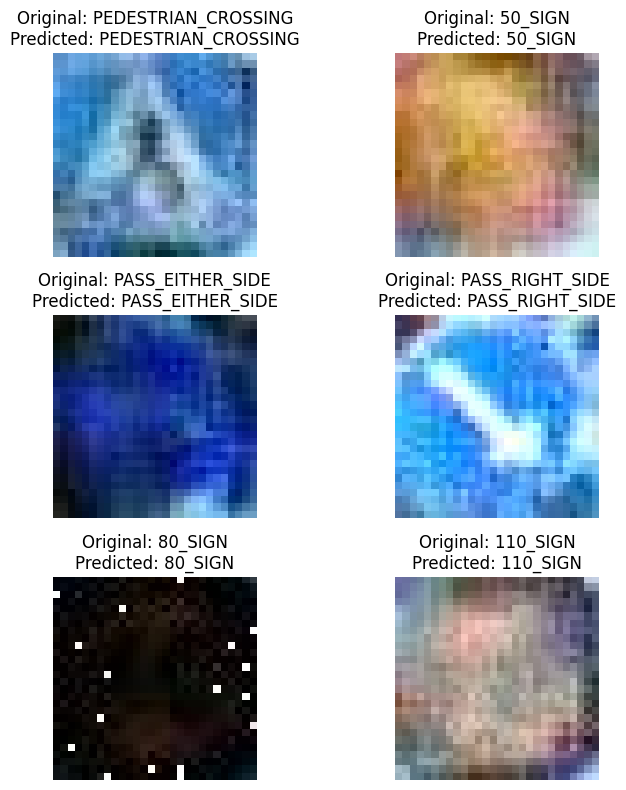

In [26]:
# Visualize Predictions

import random
from PIL import Image
import matplotlib.pyplot as plt

model = model.to(device)
model.eval()

def predict_image_class(image_path, model):
    # Load and transform the image
    image = Image.open(image_path)
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Make a prediction
    with torch.no_grad():
        output = model(image_tensor)

    # Get the predicted class
    _, predicted = torch.max(output, 1)
    predicted_class = predicted.item()

    return predicted_class

# Define the directory containing the class folders
directory = '/kaggle/working/images'
class_names = os.listdir(directory)

# Initialize an empty list to store the image paths
image_paths = []
CLASSES = []

for _ in range(6):
    random_class = random.choice(class_names)
    random_class_dir = os.path.join(directory, random_class)
    random_img = random.choice(os.listdir(random_class_dir))
    random_img_dir = os.path.join(random_class_dir, random_img)
    image_paths.append(random_img_dir)
    CLASSES.append(random_img_dir.split('/')[-2])

# Predict and plot
fig, axs = plt.subplots(3, 2, figsize=(8, 8))

for i, ax in enumerate(axs.flat):
    image_path = image_paths[i]

    # Predict the class of the image
    predicted_class = predict_image_class(image_path, model)
    
    # Load the image for plotting
    image = Image.open(image_path)

    # Display the image and its predicted class
    ax.imshow(image)
    ax.set_title(f'Original: {CLASSES[i]}\nPredicted: {classes[predicted_class]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

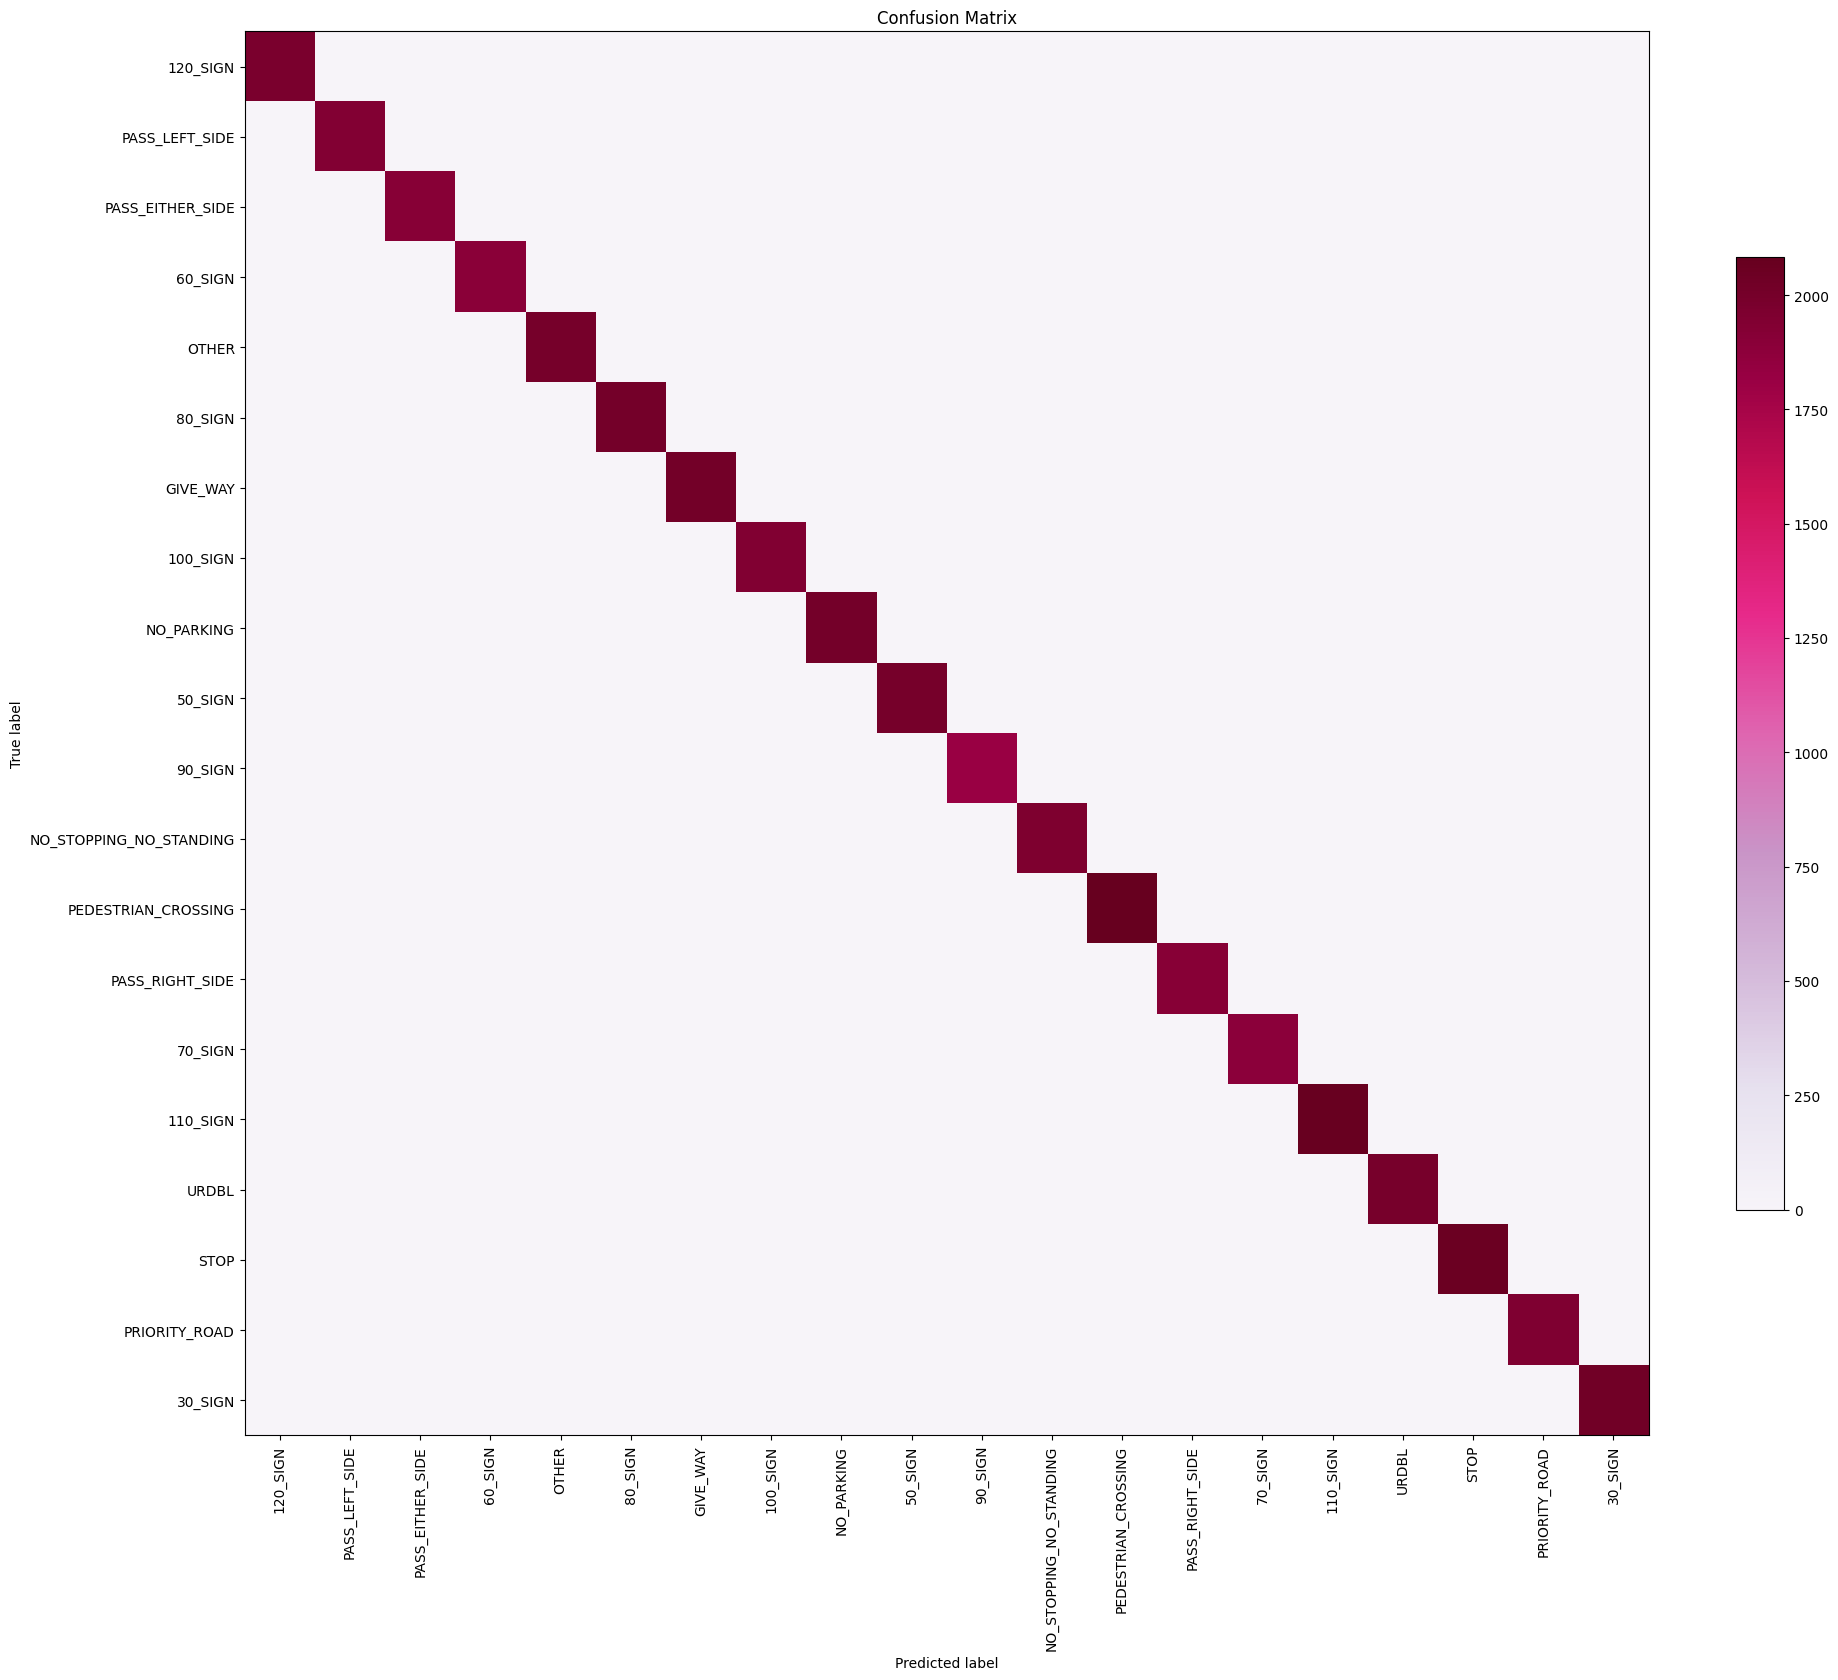

In [27]:
# Plot Confusion Matrix
y_pred_classes = torch.tensor([])
y_true = torch.tensor([])
class_names = os.listdir('/kaggle/working/images')

# Set the model to evaluation mode
model.eval()

with torch.no_grad():  # Deactivate gradients for the following code
    for x, y in val_dataloader:
        # Move the training data to the GPU
        x = x.to(device)
        y = y.to(device)
        
        # Forward pass
        out = model(x)
        
        # Predicted class is the one with highest probability
        _, predicted = torch.max(out, dim=1)
        
        # Join the predicted classes
        y_pred_classes = torch.cat([y_pred_classes, predicted.cpu()])
        
        # Join the correct classes
        y_true = torch.cat([y_true, y.cpu()])

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_true.numpy(), y_pred_classes.numpy())

plt.figure(figsize=(20, 20))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.PuRd)
plt.title('Confusion Matrix')
plt.colorbar(shrink=0.5)
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()